In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 2

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 1000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:1' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.01,
            'metric' : "DP",
            'lambda': 0.5,
            'lambda_old': 0.0,
            
              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=2_epoch=15_lr=0.001_tau=10.0_alpha=0.01_lmbd_0.5_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
benchmark.mnist_train.sensitives

array([5, 0, 4, ..., 7, 6, 8])

In [5]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [6]:
target_label = 0
incremental_step = 1
# cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
to_pil_image(unnormalize(cat_img), mode="RGB")

In [7]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [8]:
algorithm.params['dataset'] == "BiasedMNIST"

True

In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.8212217926818304, 'loss': 0.0023008350643987634, 'std': 0.0379618807875573, 'EER': -1, 'EO': [0.27111984282907664, 0.43157894736842106], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6486506049012511, 'classwise_accuracy': {0: array([842, 980]), 1: array([ 889, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 471, 1: 565}, 'class_pred_count_s1': {0: 617, 1: 462}, 'class_pred_count': {0: 1088, 1: 1027}, 'count_s0': 1036, 'count_s1': 1079, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.9089409332014744, 'loss': 0.001165850619052319, 'std': 0.01554886271689293, 'EER': -1, 'EO': [0.21228070175438596, 0.14538310412573674], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.8211680970599387, 'classwise_accuracy': {1: array([1014, 1135]), 0: array([906, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 565, 0: 471}, 'class_pred_count_s1': {0: 556, 1: 523}, 'class_pre

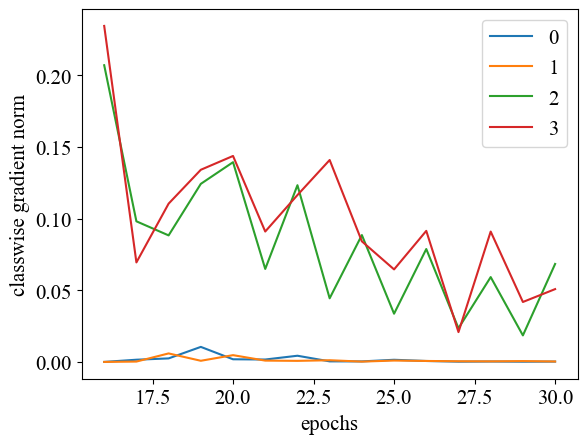

---------------------------- Task 3 -----------------------
losses=tensor([[2.9443e-04, 9.4024e-04, 5.8089e-02, 3.8486e-01, 9.8473e+00, 9.8293e+00,
         7.4360e-03, 1.0051e-02, 2.1926e-01, 3.8806e-01, 9.9103e+00, 1.1128e+01]])
Elapsed time(grad):4.721
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):7.499
Fairness:[-0.00111717  0.          0.00272862  0.          0.          0.01095354]
Current class expected loss:tensor([[ 8.0441e-01, -2.9147e-01,  1.4875e-01,  5.8314e-01,  0.0000e+00,
         -7.6153e-01,  7.1104e-01, -2.8308e-01,  4.8079e-01,  5.7530e-01,
          9.5367e-07,  7.6153e-01]])
len(updated_seq_indices)=2304
Elapsed time(etc):0.438
temporal training...
temporal training done
[31] Eval metrics for task 1 >> {'accuracy': 0.921624112199946, 'loss': 0.0011219789091295102, 'std': 0.007967724534747866, 'EER': -1, 'EO': [0.14373544480670708, 0.09468213348683363], 'DP': -1, 'accuracy_s0': 0.9823046427296469, 'accuracy_s1': 0.8630958535828765, 'cl

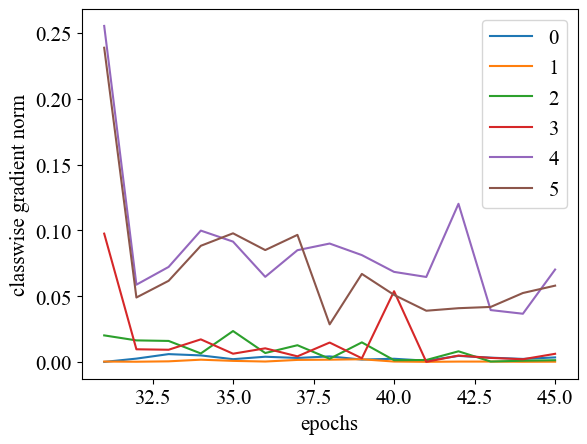

---------------------------- Task 4 -----------------------
losses=tensor([[4.9574e-03, 9.9468e-04, 7.3003e-03, 1.3003e-02, 3.1477e-01, 1.2255e-01,
         1.0406e+01, 7.4311e+00, 2.1630e-02, 2.9018e-02, 2.7751e-02, 3.9591e-02,
         7.5064e-01, 1.0111e+00, 1.0599e+01, 1.0110e+01]])
Elapsed time(grad):4.228
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.892
Fairness:[-0.00057273  0.          0.00058288  0.00074078  0.00387777  0.00739506
  0.00502784  0.02198893]
Current class expected loss:tensor([[-0.9474, -0.8496,  1.1009, -0.7324,  0.8068, -0.0219, -0.4100, -1.6540,
         -1.1053, -0.8251,  1.2007, -0.6081,  1.3977,  1.4221,  0.4100,  1.6540]])
len(updated_seq_indices)=2240
Elapsed time(etc):0.233
temporal training...
temporal training done
[46] Eval metrics for task 1 >> {'accuracy': 0.8927739818394318, 'loss': 0.0016072557891232465, 'std': 0.02440663490065631, 'EER': -1, 'EO': [0.10852352119236142, 0.16350698050796908], 'DP': -1, 'accuracy_s

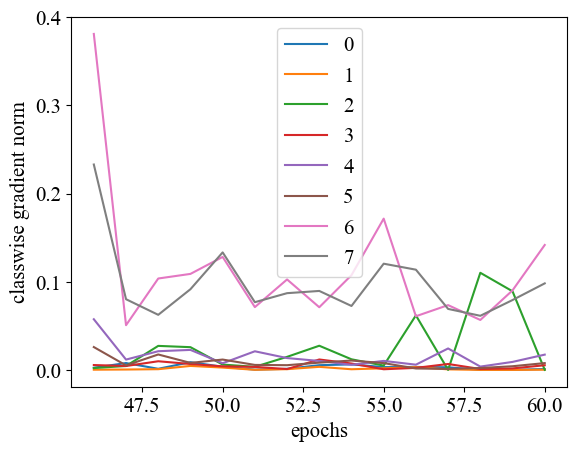

---------------------------- Task 5 -----------------------
losses=tensor([[1.0872e-02, 9.1784e-03, 1.1967e-02, 1.4251e-03, 3.4411e-03, 1.8870e-02,
         1.4588e-01, 5.9357e-01, 8.6802e+00, 1.2987e+01, 6.0332e-03, 5.7631e-01,
         1.0170e-01, 7.8452e-02, 8.7468e-02, 1.7023e-01, 6.9195e-01, 1.0244e+00,
         1.0374e+01, 1.1349e+01]])
Elapsed time(grad):3.437
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):14.828
Fairness:[-0.00023563  0.          0.00180056  0.         -0.00073944  0.00132246
  0.          0.00130081  0.01102849 -0.00657809]
Current class expected loss:tensor([[-0.9283, -0.1373, -1.3967, -0.0623,  4.3118, -0.3063, -0.1065, -1.4890,
         -1.1238,  0.6550, -1.0372, -0.1334, -1.0393, -0.0614,  4.0231, -0.0167,
         -0.1078, -1.1901,  1.1238, -0.6550]])
len(updated_seq_indices)=2560
Elapsed time(etc):0.225
temporal training...
temporal training done
[61] Eval metrics for task 1 >> {'accuracy': 0.8854737930414456, 'loss': 0.00174

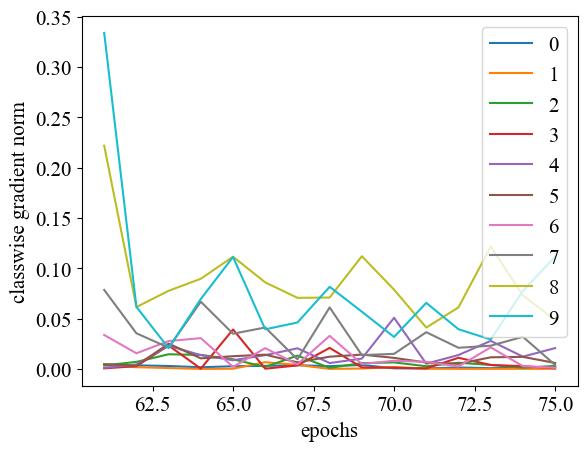

final avg-acc 0.7976311065139098
final avg-forget 0.07514190266714604


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [11]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")

92.1159	70.2452	72.0455	47.488	
98.4711	109.2985	168.8166	187.2562	
4.2421	3.6494	3.4877	4.2697	
305.9472	324.259	350.939	366.4683	

In [12]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = list()
    groupwise_expected_loss[i] = list()
    for j in range(2):
        groupwise_true_loss[i].append(dict())
        groupwise_expected_loss[i].append(dict())


for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            if i < num_class_per_task*task:
                groupwise_true_loss[i][0][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i][0][(task-1)*num_epochs+epoch] = el
            else:
                groupwise_true_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = el

            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


In [13]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][0][ce], end='\t')
    print()


0.0002	0.0121	0.027	0.0826	0.0171	0.0153	0.0219	0.0028	0.0018	0.0059	0.0025	0.0008	0.001	0.0006	0.0007	0.01	0.0142	0.0277	0.017	0.0097	0.0159	0.0127	0.0142	0.0056	0.0074	0.0045	0.0207	0.0106	0.0079	0.0102	0.0021	0.0134	0.0044	0.0346	0.0091	0.001	0.0043	0.0134	0.0148	0.0076	0.0063	0.005	0.0004	0.0006	0.0034	0.0021	0.0108	0.0089	0.0038	0.0075	0.0082	0.008	0.008	0.0107	0.0016	0.001	0.0022	0.0019	0.0028	0.0023	
0.0001	0.0032	0.0288	0.0099	0.0354	0.0054	0.0072	0.0057	0.002	0.0044	0.0033	0.0017	0.0018	0.0019	0.0011	0.0007	0.0015	0.0021	0.0077	0.0041	0.002	0.0066	0.0085	0.0069	0.0015	0.0007	0.0012	0.0011	0.0006	0.0008	0.0004	0.0026	0.006	0.0281	0.0088	0.0011	0.0092	0.0123	0.0043	0.0065	0.0085	0.0032	0.0004	0.0005	0.003	0.0191	0.0066	0.0028	0.0001	0.0015	0.0248	0.0134	0.0004	0.0018	0.0059	0.0007	0.0003	0.0003	0.0003	0.0004	
3.256	0.9072	0.5465	0.7748	0.7971	0.3477	0.3748	0.2241	0.1907	0.1333	0.1765	0.0938	0.1385	0.0851	0.1481	0.2562	0.2268	0.1303	0.1627	0.1837	0.0702	0.0836	0.0359	0.0715	0.009

In [14]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][1][ce], end='\t')
    print()


0.098	0.0986	0.1595	0.2702	0.0825	0.1294	0.0891	0.0744	0.0462	0.0268	0.0391	0.0158	0.0196	0.0128	0.0124	0.0247	0.0396	0.0484	0.0461	0.0551	0.039	0.0354	0.0385	0.0223	0.0365	0.0198	0.0735	0.0271	0.0206	0.0316	0.0143	0.0909	0.0373	0.1232	0.2678	0.0137	0.1158	0.0145	0.018	0.0163	0.0082	0.0609	0.0213	0.0198	0.0112	0.009	0.0249	0.0339	0.0235	0.0139	0.0186	0.0131	0.0316	0.0458	0.011	0.0163	0.0324	0.0193	0.0118	0.0059	
0.0937	0.1531	0.1122	0.0981	0.1475	0.1107	0.0884	0.0413	0.0666	0.0294	0.101	0.0401	0.0369	0.0243	0.0225	0.027	0.1116	0.0608	0.0752	0.1175	0.0666	0.0508	0.0738	0.0361	0.0406	0.0378	0.0326	0.0328	0.0223	0.0264	0.0739	0.0978	0.1054	0.0822	0.0532	0.1393	0.0638	0.2513	0.0788	0.1141	0.3174	0.0855	0.0547	0.0303	0.0275	0.342	0.2169	0.1351	0.0726	0.1573	0.0991	0.2061	0.234	0.0241	0.0529	0.0886	0.0274	0.0537	0.0133	0.028	
4.4738	2.1836	1.5635	1.274	1.2236	0.9162	0.8647	0.6796	0.6367	0.5413	0.4223	0.4206	0.3024	0.3102	0.2959	0.4388	0.1269	0.1502	0.2464	0.2482	0.1813	0.1011	0.131	0.0836	0.

In [15]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][0][ce], end='\t')
    print()


-0.0506	1.6108	1.9902	2.0187	1.5888	1.9891	1.3258	1.6549	1.1092	1.0625	0.9857	1.4004	0.8652	1.1464	0.7612	0.8044	0.9918	1.0851	0.915	1.0101	1.3457	0.8399	0.7879	0.5391	0.8033	0.9481	0.9615	1.016	1.2889	0.9754	-0.9474	-0.3434	-0.0381	0.245	-0.0315	0.0004	0.0368	0.108	0.0544	0.0323	-0.131	0.041	-0.0708	0.0016	-0.0313	-0.9283	-0.3163	-0.0847	-0.3875	-0.0626	0.0132	-0.3463	-0.0291	-0.0002	-0.0519	-0.0752	-0.3018	0.0103	-0.0418	-0.3186	
0.891	1.7702	0.8392	1.5903	1.6355	1.0915	1.669	1.0822	1.035	1.1795	1.2692	0.8625	0.9499	0.8616	0.5489	-0.2915	-0.0062	0.5436	0.5574	0.4774	0.5574	0.6053	0.5507	0.4349	0.5945	0.4329	0.5732	0.3949	0.4193	0.431	-0.8496	-0.0421	0.4869	0.3491	0.2166	0.5003	0.6838	0.4379	0.2659	1.2649	0.3054	0.497	0.3073	0.3595	0.7935	-0.1373	-0.2351	0.1886	0.0996	0.0177	0.4547	0.1695	0.1574	0.3434	0.3413	0.2388	0.0059	0.1838	0.2089	0.1362	
-0.1641	-0.6289	-0.494	0.0	0.0	-0.0302	-0.0	-0.0484	-0.2553	-0.0492	-0.0006	-0.1265	-0.0024	-0.0	-0.0727	0.1487	1.3413	0.9907	1.5351	1.2182	1.

In [16]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][1][ce], end='\t')
    print()


-0.0538	1.8029	2.0454	2.3405	1.6886	2.0035	1.4161	1.7559	1.366	1.0579	1.0477	1.508	0.9755	1.2184	0.8118	0.711	0.902	1.1182	0.9407	1.063	1.309	0.8536	0.8454	0.5566	0.8472	1.0077	1.022	1.0437	1.3076	0.9687	-1.1053	-0.0365	0.2002	0.5647	0.5465	0.1701	0.3889	0.0544	0.0528	0.2158	-0.1419	0.322	0.0519	0.056	0.0945	-1.0372	-0.1381	0.1703	-0.2432	0.1209	0.0583	-0.368	0.1852	0.0222	0.2528	0.2626	-0.1388	0.1565	-0.0445	-0.3386	
0.8654	1.7193	0.9078	1.6049	1.8409	1.3994	1.6845	1.1788	1.0932	1.3037	1.555	0.9938	1.0199	0.8966	0.6588	-0.2831	0.1095	0.2898	0.2483	0.4469	0.3733	0.432	0.4614	0.4024	0.3225	0.1448	0.443	0.2875	0.3832	0.197	-0.8251	0.4926	0.4729	0.4502	0.3624	0.4604	0.6641	0.4831	0.2786	1.2285	0.496	0.3358	0.2984	0.4113	0.8381	-0.1334	-0.1383	0.038	0.1678	0.115	0.3681	0.1498	0.3311	0.0489	0.0237	0.0312	0.0057	-0.0162	0.0843	0.0084	
0.1641	0.6289	0.494	0.0	0.0	0.0302	0.0	0.0484	0.2553	0.0492	0.0006	0.1265	0.0024	-0.0	0.0727	0.4808	1.3522	0.9957	1.5627	1.2624	1.1516	0.9772	1.3086	0.6239	0.7

In [17]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"DP:{np.mean(metric_manager_callback.meters['DP'].compute_overall())}")
print(f"EO:{np.mean(metric_manager_callback.meters['EO'].compute_overall())}")


accuracy:0.8812198626557164
DP:0.005720032441601521
EO:0.1440298644295291
